**Лабораторная работа №2**

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from typing import Tuple, List

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

Используется устройство: cuda


1. Загрузка и преобразование данных

In [67]:
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD = (0.2023, 0.1994, 0.2010)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./cifar_data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./cifar_data',
    train=False,
    download=True,
    transform=transform
)

BATCH_SIZE = 64
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

print(f"Размер тренировочной выборки: {len(train_dataset)} изображений")
print(f"Размер тестовой выборки: {len(test_dataset)} изображений")

class_names = ('самолёт', 'автомобиль', 'птица', 'кошка',
               'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик')

Размер тренировочной выборки: 50000 изображений
Размер тестовой выборки: 10000 изображений


2. Визуализация примеров изображений

Примеры из тренировочного набора:


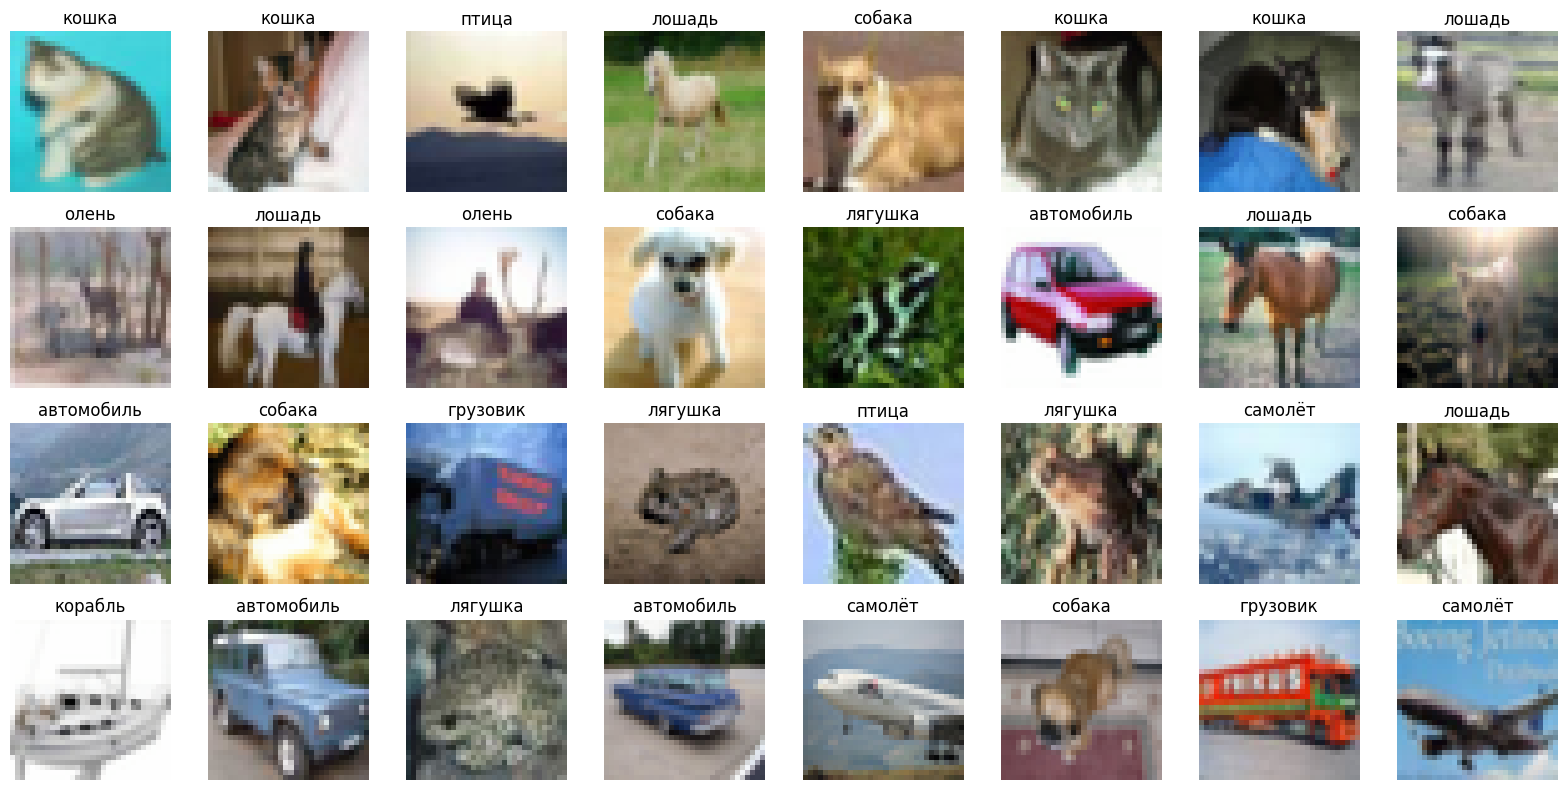

Примеры из тестового набора:


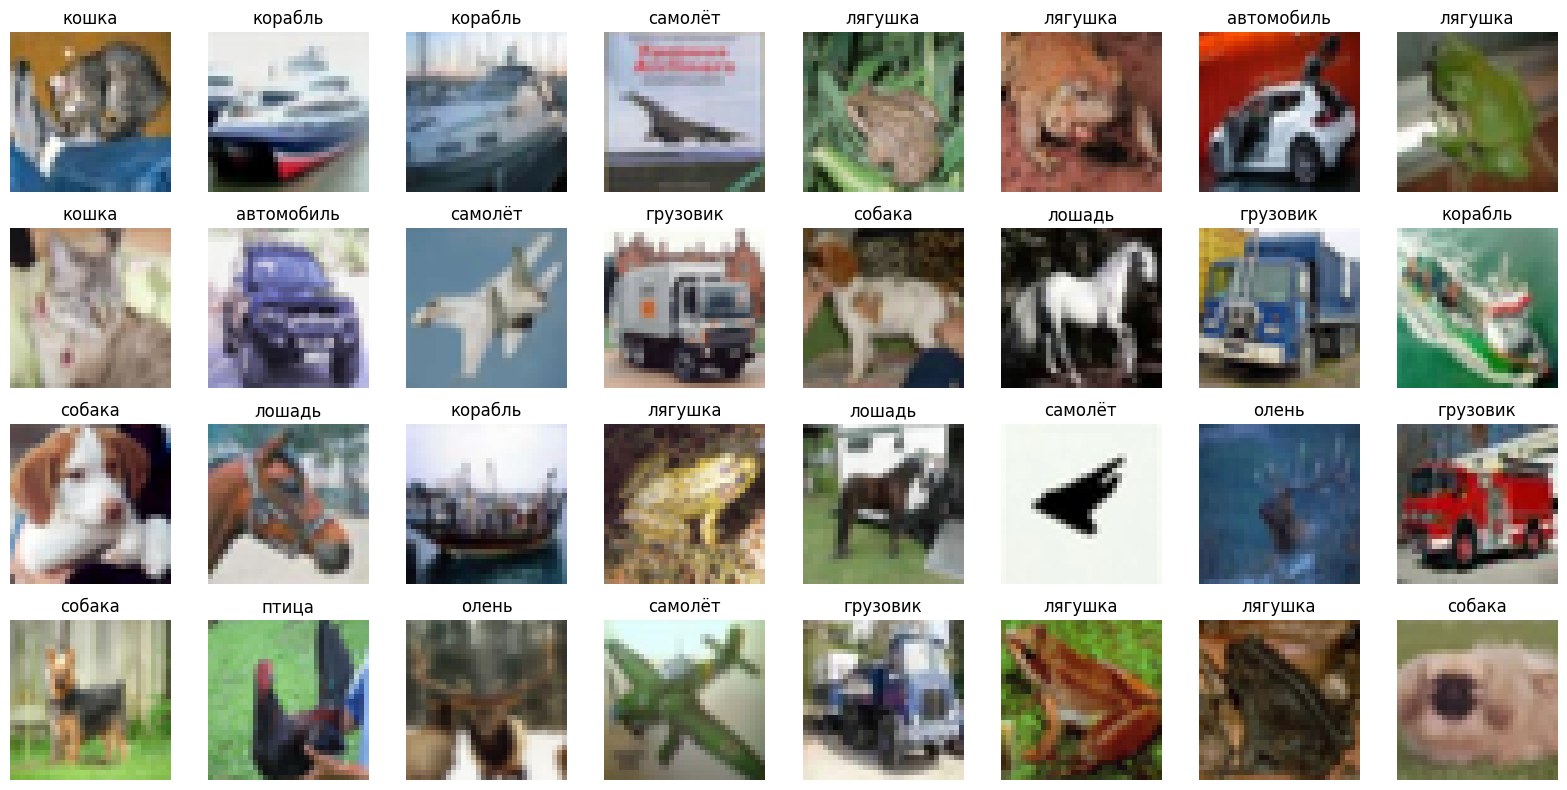

In [68]:
def tensor_to_image(tensor: torch.Tensor) -> np.ndarray:
    img = tensor.cpu().clone().detach().numpy()
    img = img.transpose(1, 2, 0)
    img = img * CIFAR_STD + CIFAR_MEAN
    img = np.clip(img, 0, 1)
    return img

def display_sample_images(loader: DataLoader, rows: int = 4, cols: int = 8) -> None:
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
    axes = axes.flatten()

    for i in range(rows * cols):
        ax = axes[i]
        ax.imshow(tensor_to_image(images[i]))
        ax.set_title(class_names[labels[i].item()])
        ax.axis('off')
    plt.tight_layout()
    plt.show()



print("Примеры из тренировочного набора:")
display_sample_images(train_loader, rows=4, cols=8)



print("Примеры из тестового набора:")
display_sample_images(test_loader, rows=4, cols=8)

3. Определение архитектуры сети

In [69]:
class SimpleVGG(nn.Module):
    #Упрощённая версия VGG
    #Состоит из трёх блоков свёрток с пулингом и двух полносвязных слоёв.
    #Количество каналов наращивается постепенно: 32-64-128.
    def __init__(self, num_classes: int = 10):
        super(SimpleVGG, self).__init__()

        config = [32, 32, 'p', 64, 64, 'p', 128, 128, 'p']

        self.features = self._make_layers(config)

        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'p':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                layers.append(nn.Conv2d(in_channels, x, kernel_size=3, padding=1))
                layers.append(nn.BatchNorm2d(x))
                layers.append(nn.ReLU(inplace=True))
                in_channels = x
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



model = SimpleVGG(num_classes=len(class_names)).to(device)

print(model)

SimpleVGG(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128

4. Настройка гиперпараметров

In [70]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 30

# Функция потерь - кросс-энтропия
criterion = nn.CrossEntropyLoss()

# Оптимизатор - Adam (адаптивный градиентный спуск)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

5. Обучение модели

In [71]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    epochs: int,
    criterion: nn.Module,
    optimizer: optim.Optimizer
):
    model.train()
    loss_history = []
    acc_history = []

    for epoch in range(epochs):
        epoch_start = time.time()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)

        elapsed = time.time() - epoch_start
        print(f"Эпоха [{epoch+1}/{epochs}] "
              f"Loss: {epoch_loss:.4f} "
              f"Accuracy: {epoch_acc:.2f}% "
              f"Время: {elapsed:.2f} сек")

    return loss_history, acc_history


print("Начинаем обучение упрощённой модели...")
train_losses, train_accuracies = train_model(model, train_loader, NUM_EPOCHS, criterion, optimizer)

Начинаем обучение упрощённой модели...
Эпоха [1/30] Loss: 1.5401 Accuracy: 43.38% Время: 14.86 сек
Эпоха [2/30] Loss: 1.1256 Accuracy: 61.05% Время: 14.80 сек
Эпоха [3/30] Loss: 0.9451 Accuracy: 67.71% Время: 15.53 сек
Эпоха [4/30] Loss: 0.8185 Accuracy: 72.63% Время: 15.03 сек
Эпоха [5/30] Loss: 0.7329 Accuracy: 75.50% Время: 14.86 сек
Эпоха [6/30] Loss: 0.6593 Accuracy: 78.02% Время: 14.85 сек
Эпоха [7/30] Loss: 0.6029 Accuracy: 80.10% Время: 15.35 сек
Эпоха [8/30] Loss: 0.5408 Accuracy: 82.31% Время: 15.14 сек
Эпоха [9/30] Loss: 0.4938 Accuracy: 83.68% Время: 14.74 сек
Эпоха [10/30] Loss: 0.4497 Accuracy: 85.43% Время: 14.80 сек
Эпоха [11/30] Loss: 0.4043 Accuracy: 86.77% Время: 14.85 сек
Эпоха [12/30] Loss: 0.3748 Accuracy: 87.74% Время: 15.43 сек
Эпоха [13/30] Loss: 0.3395 Accuracy: 88.95% Время: 14.75 сек
Эпоха [14/30] Loss: 0.3074 Accuracy: 90.11% Время: 14.79 сек
Эпоха [15/30] Loss: 0.2812 Accuracy: 90.94% Время: 14.76 сек
Эпоха [16/30] Loss: 0.2640 Accuracy: 91.42% Время: 15.0

6. Построение графиков потерь и точности

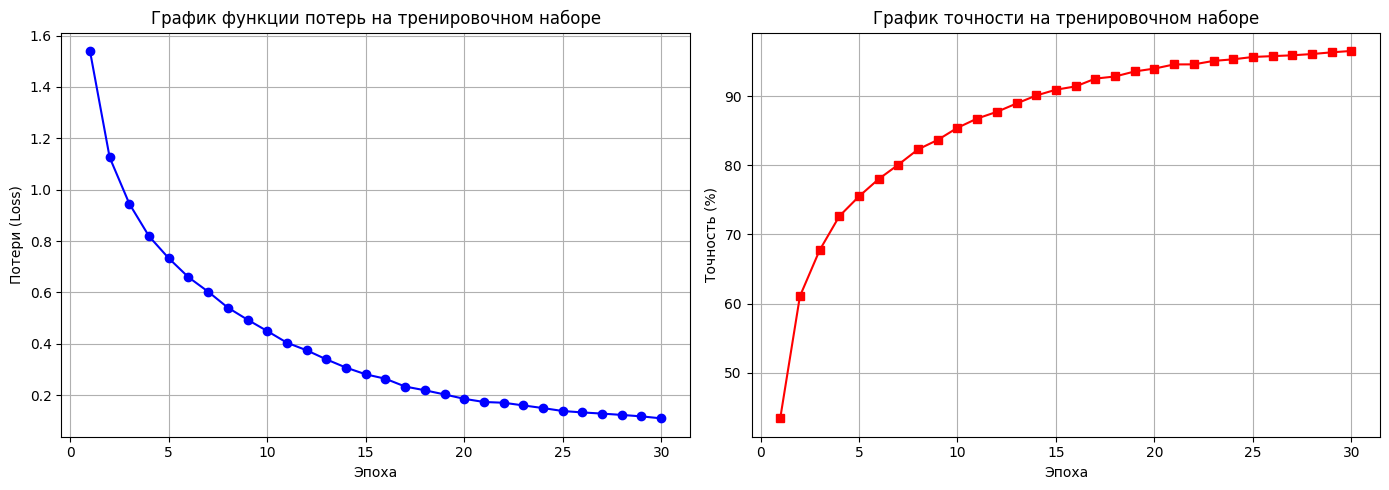

In [72]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, marker='o', color='blue', linestyle='-')
plt.title('График функции потерь на тренировочном наборе')
plt.xlabel('Эпоха')
plt.ylabel('Потери (Loss)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, marker='s', color='red', linestyle='-')
plt.title('График точности на тренировочном наборе')
plt.xlabel('Эпоха')
plt.ylabel('Точность (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

7. Оценка на тестовом наборе

In [73]:
def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader,
    criterion: nn.Module
) -> Tuple[float, float]:
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    avg_test_loss = test_loss / total
    accuracy = 100.0 * correct / total
    return accuracy, avg_test_loss

test_acc, test_loss_val = evaluate_model(model, test_loader, criterion)
print(f"\nРезультаты на тестовом наборе:")
print(f"Точность: {test_acc:.2f}%")
print(f"Средние потери: {test_loss_val:.4f}")


Результаты на тестовом наборе:
Точность: 84.22%
Средние потери: 0.7711
